# Homework 5: Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

**Fernando Hernández Gant: 100318091**

------------------------------------------------------

The aim of this homework is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). 

The problem is the prediction of the house prices using the Housing Data Set from  <a href = https://archive.ics.uci.edu/ml/datasets/Housing>  UCI repository</a> that you can also download from scikit learn <a href = http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html> here</a>.


### 1. Loading and preparing the data (1 point)

* Download the dataset
* Divide the dataset into train (400) and test (106) datasets
* Check the range of prices in the train and test datasets

In [1]:
import GPy
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

#Download the dataset
load_boston(return_X_y=True)
data = load_boston()
X = data["data"]
Y = data["target"]

#Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.209, random_state=42)
#Reshape the data: y from (N) to (N,1)
y_test = y_test.reshape((y_test.shape[0],1))
y_train = y_train.reshape((y_train.shape[0],1))


print(X_train.data.shape)

(400, 13)


The data contains 506 census tracts and 13 features of Boston from the 1970 census. Some of the features are:

> **zn**: Proportion of residential land zoned for lots over 25,000 sq.ft 

> **indus**: Proportion of non-retail business acres per town 

> **chas**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 

> **nox**: Nitric oxides concentration (parts per 10 million) 

> **rm**: Average number of rooms per dwelling 

> **age**: Proportion of owner-occupied units built prior to 1940 

> **dis**: Weighted distances to five Boston employment centres 

> **rad**: Index of accessibility to radial highways 

In [2]:
#Check the range of prices
print("The range in train is: {} - {}".format(min(y_train),max(y_train)))
print("The range in test is: {} - {}".format(min(y_test),max(y_test)))

The range in train is: [5.] - [50.]
The range in test is: [5.] - [50.]


The minimum and the maximum value in both sets, training and test, are the same.

### 2. Setting and optimizing the model

On the training data set:

a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale. This enhances interpretability. **2 points**

b) Fit the covariance function parameters and noise to the data. **1 point** 

c) Plot the parameters found for the covariance function. What variables are more important for the regression? **2 points**

On the test data set:

d) Plot and evaluate the prediction error using the opmitized parameters. **2 points**

2) Try to combine various covariance functions using the element-wise product or the sum of two kernels, and repeat steps b) and c). Comments the results. **2 points**

In this [link](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) you can see how to define differnt kernels and operate with them.

#### On the training data set:

#####  a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale. This enhances interpretability. 2 points

In [3]:
warnings.filterwarnings("ignore")
# define kernel
start = time.time()
ker1 = GPy.kern.RBF(X_train.shape[1],ARD=True)

# create simple GP model
m = GPy.models.GPRegression(X_train,y_train ,ker1)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
m.optimize_restarts(num_restarts = 10)
end = time.time()
print("Elapse time : {0:2f}s".format(end - start))
display(m)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s13  0001   6.129924e+04   7.335833e+08 
    02s23  0022   1.165875e+03   6.915021e+01 
    03s29  0032   1.049212e+03   1.241279e+00 
    08s43  0110   1.037120e+03   1.782537e+00 
    14s70  0207   1.036395e+03   3.676163e-02 
    19s93  0283   1.036198e+03   1.116159e-03 
    42s84  0589   1.036070e+03   1.110809e-04 
    59s87  0792   1.036022e+03   3.631018e-06 
Runtime:     59s87
Optimization status: Converged

Optimization restart 1/10, f = 1036.0218908969246
Optimization restart 2/10, f = 1428.2022571851362
Optimization restart 3/10, f = 1033.3373190117518
Optimization restart 4/10, f = 1204.0228239951318
Optimization restart 5/10, f = 1053.0020560210717
Optimization restart 6/10, f = 1069.434826265531
Optimization restart 7/10, f = 1036.0227065122237
Optimization restart 8/10, f = 1437.159914590335
Optimization restart 9/10, f = 1035.1262277136336
Optimization restart 10/10, f = 1

GP_regression.,value,constraints,priors
rbf.variance,792.728861760799,+ve,
rbf.lengthscale,"(13,)",+ve,
Gaussian_noise.variance,5.413479590595016,+ve,


In [4]:
m.grep_param_names(regexp="")

[<GPy.kern.src.rbf.RBF at 0x22b4abf3400>, GP_regression.rbf.variance:
 Param([792.72886176]), GP_regression.rbf.lengthscale:
 Param([ 473.95444671, 2553.22340718,  144.06828806,    4.24696703,
           2.62568254,    4.23747496,  238.57968474,   12.67925427,
         196.37085609,  186.20880489,   30.22983773,  817.35285175,
          15.47804221]), <GPy.likelihoods.gaussian.Gaussian at 0x22b4abf3550>, GP_regression.Gaussian_noise.variance:
 Param([5.41347959])]

The final value of the objective function is around 1032. We have optimized 15 parameters, 13 lengthscales (one per dimension as we have used ARD), 1 single variance RBF hyperparameter and another variance to modelize Gaussian noise. The values of the parameter are above. 


#####  b) Fit the covariance function parameters and noise to the data. 1 point

In [5]:
warnings.filterwarnings("ignore")
# define kernel
ker1 = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.White(X_train.shape[1])

# create simple GP model
m = GPy.models.GPRegression(X_train,y_train ,ker1)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
m.optimize_restarts(num_restarts = 10)

display(m)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0001   4.115594e+04   2.170664e+08 
    02s19  0025   1.140096e+03   5.071574e+02 
    03s23  0039   1.051348e+03   3.073939e+00 
    06s36  0083   1.040959e+03   1.027652e+00 
    18s80  0263   1.034723e+03   5.956204e-02 
    31s14  0431   1.032649e+03   5.659543e-02 
    38s39  0545   1.032435e+03   1.143080e-03 
    52s15  0758   1.031732e+03   2.152852e+01 
Runtime:     52s15
Optimization status: Converged

Optimization restart 1/10, f = 1029.8956414340246
Optimization restart 2/10, f = 1624.8490010935807
Optimization restart 3/10, f = 1263.1135696106908
Optimization restart 4/10, f = 1143.9167280113593
Optimization restart 5/10, f = 1637.0166917009556
Optimization restart 6/10, f = 1088.8696165612437
Optimization restart 7/10, f = 1032.7253769883318
Optimization restart 8/10, f = 1035.1157166976184
Optimization restart 9/10, f = 1437.1599145929283
Optimization restart 10/10, f =

GP_regression.,value,constraints,priors
sum.rbf.variance,495.01402579201107,+ve,
sum.rbf.lengthscale,"(13,)",+ve,
sum.white.variance,2.1483203705804352,+ve,
Gaussian_noise.variance,2.1483203705804352,+ve,


Here we have now 16 parameters, the same than before but with an extra one that corresponds to the white noise kernel we have added. Now the value of the objective function is slightly lower than before.


#### c) Plot the parameters found for the covariance function. What variables are more important for the regression? 2 points

In [6]:
ker1.input_sensitivity()

array([1.08302682e-01, 4.57973775e-04, 1.16303495e-03, 6.10014450e+01,
       3.39477639e+04, 5.38898945e+01, 8.00650354e-03, 5.45728995e-01,
       2.43595973e-01, 1.89808980e-02, 4.12394582e-01, 1.46759524e-04,
       8.08101497e-01])

In [7]:
m.get_most_significant_input_dimensions()

(4, 3, 5)

In [8]:
data.feature_names[3:6]

array(['CHAS', 'NOX', 'RM'], dtype='<U7')

In [9]:
m.grep_param_names(regexp="")

 GP_regression.sum.rbf.variance:
 Param([495.01402579]),
 GP_regression.sum.rbf.lengthscale:
 Param([6.76066078e+01, 1.03965309e+03, 6.52397622e+02, 2.84864736e+00,
        1.20754456e-01, 3.03078470e+00, 2.48649335e+02, 3.01175915e+01,
        4.50789405e+01, 1.61491763e+02, 3.46459342e+01, 1.83656205e+03,
        2.47500338e+01]),
 GP_regression.sum.white.variance:
 Param([2.14832037]),
 GP_regression.Gaussian_noise.variance:
 Param([2.14832037])]

It is clearly seen that there are lenghtscales very different for some dimensions. As the ARD kernel formula is $K_{nn`}=v \cdot exp^{-1\frac{1}{2} \sum_{d=1}^{D} (\frac{x_{n}^{(d)}-x_{n`}^{(d)}}{rd})^{2}}$ where $rd$ is the lentgth-scale, if $rd \rightarrow \infty$, the function $f$ varies less and less as a function of $x$, so the dth dimension becomes irrelevant. In such way we can performe a feature selection by looking at the lower values of the length-scale parameter. Those are the 4,5 and 6 that correspond with CHAS, NOX and RM. It is also possible to use the sensitivity (a measure of how variance explain each input dimension in the output) to select the most important input dimensions. In the sensitivity matrix it is clearly seen that the most important variables are also the 4,5 and 6 dimensions. This corresponds with the dimensions with lower length scale. 

#### On the test data set:

##### d) Plot and evaluate the prediction error using the opmitized parameters. 2 points

In [10]:
# define kernel
ker2 = GPy.kern.RBF(len(m.get_most_significant_input_dimensions())-1,ARD=True) + GPy.kern.White(len(m.get_most_significant_input_dimensions())-1)

# create simple GP model
m2 = GPy.models.GPRegression(X_train[:,m.get_most_significant_input_dimensions()[:2]],y_train ,ker2)

# optimize and plot
m2.optimize(messages=True,max_f_eval = 1000)
m2.optimize_restarts(num_restarts = 10)
display(m2)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0003   4.222564e+03   7.907258e+05 
    02s23  0042   1.372112e+03   7.308595e-01 
    02s47  0047   1.372103e+03   4.828095e-07 
Runtime:     02s47
Optimization status: Converged

Optimization restart 1/10, f = 1372.1028659499163
Optimization restart 2/10, f = 1417.042839151839
Optimization restart 3/10, f = 1389.2468171777502
Optimization restart 4/10, f = 1389.2468171725764
Optimization restart 5/10, f = 1372.5506363953743
Optimization restart 6/10, f = 1381.1511047533854
Optimization restart 7/10, f = 1372.102865957645
Optimization restart 8/10, f = 1389.246817172538
Optimization restart 9/10, f = 1372.55063646316
Optimization restart 10/10, f = 1372.5506363978404


GP_regression.,value,constraints,priors
sum.rbf.variance,501.00636183568275,+ve,
sum.rbf.lengthscale,"(2,)",+ve,
sum.white.variance,18.717546859878514,+ve,
Gaussian_noise.variance,18.717546859878514,+ve,


In [11]:
m2.grep_param_names(regexp="")

 GP_regression.sum.rbf.variance:
 Param([501.00636184]),
 GP_regression.sum.rbf.lengthscale:
 Param([0.01219091, 1.84543791]),
 GP_regression.sum.white.variance:
 Param([18.71754686]),
 GP_regression.Gaussian_noise.variance:
 Param([18.71754686])]

We have selected only the three most important parameters in terms of sensitivity and also fitted the model again. Now we have only optimiced 6 parameters (3 of them for the 3 dimensions, the variance of the RBF kernel and the two noise's variances). The final value of the objetive function is greater than the others before, around 1182 against 1029 (adding the white noise kenel). After that, lets compute the prediction error: 

###### Predictions

We will use the MAPE (mean absolute percentage error) as a measure of the error commited. This will give us an idea of how far are we from the true value.

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

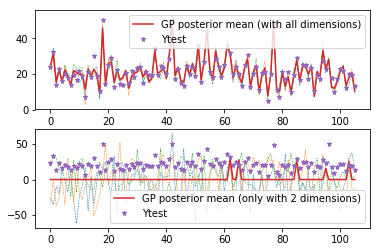

In [18]:
posteriorYtest2 = m2.posterior_samples_f(X_test, full_cov=True, size=3)
meanYtest2,a = m2.predict(X_test,full_cov=True)

posteriorYtest2_all = m.posterior_samples_f(X_test, full_cov=True, size=3)
meanYtest2_all,a = m.predict(X_test,full_cov=True)

plt.figure()

plt.subplot(2,1,1)
plt.plot(posteriorYtest2_all,'--',lw=0.5)
plt.plot(meanYtest2_all,label='GP posterior mean (with all dimensions)')
plt.plot(y_test,'*',ms=5,label='Ytest')
plt.legend()

plt.subplot(2,1,2)
plt.plot(posteriorYtest2,'--',lw=0.5)
plt.plot(meanYtest2,label='GP posterior mean (only with 2 dimensions)')
plt.plot(y_test,'*',ms=5,label='Ytest')
plt.legend()
plt.show()

In [24]:
print("MAPE error only the best 2 dimensions {}".format(mean_absolute_percentage_error(y_test, meanYtest2)))
print("MAPE error with all dimensions {}".format(mean_absolute_percentage_error(y_test, meanYtest2_all)))

MAPE error only the best 2 dimensions 96.35858783449461
MAPE error with all dimensions 10.241555496471808


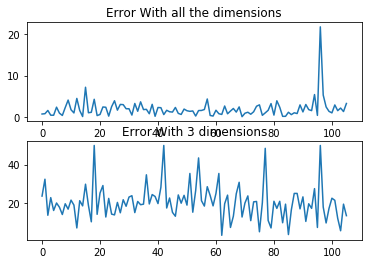

In [26]:
plt.subplot(2,1,2)
plt.plot(np.abs(y_test-meanYtest2))
plt.title("Error With 3 dimensions")
plt.subplot(2,1,1)
plt.plot(np.abs(y_test-meanYtest2_all))
plt.title("Error With all the dimensions")
plt.show(1)

The error is almost 99% with only 2 dimensions, which means that we have a lot of error and around 10% with all the dimensions. Although we have selected the most important features, we lost a lot of information if we do not select the rest of them. That is why we reduce a lot the error taking all the dimensions.

##### Try to combine various covariance functions using the element-wise product or the sum of two kernels, and repeat steps b) and c). Comments the results


Bellow, we have different kind of kernel we can use:

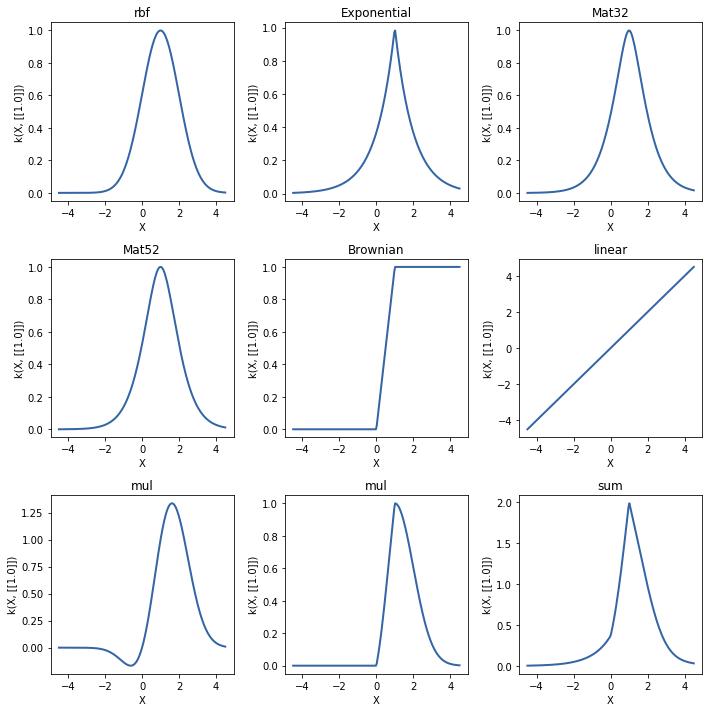

In [27]:
warnings.filterwarnings("ignore")
figure, axes = plt.subplots(3,3, figsize=(10,10), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), GPy.kern.Matern52(1), GPy.kern.Brownian(1)
         , GPy.kern.Linear(1),GPy.kern.RBF(1)*GPy.kern.Linear(1),GPy.kern.Brownian(1)*GPy.kern.RBF(1),
        GPy.kern.RBF(1)*GPy.kern.Brownian(1)+GPy.kern.Exponential(1)]
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=1)
    a.set_title(k.name.replace('_', ' '))
plt.show()
#k_prod = k1 *k2

We will try with different kernels for different dimensions. The selection of which kernel goes with each dimensions was performed by looking the sccater plot of each predictors against the response variable. We have modelized the ones that had a discrete response with the Brownian Kernel and the others with the Exponential (which is very pointed) and the Mat52 (with a similar shape to the RBF kernel).

In [28]:
warnings.filterwarnings("ignore")
# define kernel
Exponential_kernel = GPy.kern.Exponential(input_dim=1,active_dims=[2],ARD=True)
Matern52_kernel = GPy.kern.Matern52(input_dim=10, active_dims=[0,5,1,4,6,7,8,3,11,12],ARD=True)

Brownian_kernel1 = GPy.kern.Brownian(input_dim=1, active_dims=[3])
Brownian_kernel3 = GPy.kern.Brownian(input_dim=1, active_dims=[9])
Brownian_kernel4 = GPy.kern.Brownian(input_dim=1, active_dims=[10])

Ker_mul = Matern52_kernel+Brownian_kernel1+Brownian_kernel4+Brownian_kernel3+Exponential_kernel

# create simple GP model
m_mul = GPy.models.GPRegression(X_train,y_train ,Ker_mul)

# optimize and plot
m_mul.optimize(messages=True,max_f_eval = 1000)
m_mul.optimize_restarts(num_restarts = 10)

display(m_mul)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.849684e+03           nan 
    00s12  0001   4.849684e+03   3.061347e+06 
    02s31  0018   1.144503e+03   7.684027e+02 
    03s51  0029   1.086943e+03   2.644736e+01 
Runtime:     03s51
Optimization status: Converged

Optimization restart 1/10, f = 1013.0039317035154
Optimization restart 2/10, f = 1087.6508252386625
Optimization restart 3/10, f = 1028.9414837189165
Optimization restart 4/10, f = 1009.1876760709584
Optimization restart 5/10, f = 1008.8714307111236
Optimization restart 6/10, f = 1141.0352922858929
Optimization restart 7/10, f = 1008.6620024032468
Optimization restart 8/10, f = 1028.3194853965329
Optimization restart 9/10, f = 1034.9361642256324
Optimization restart 10/10, f = 1010.9853398616373


GP_regression.,value,constraints,priors
sum.Mat52.variance,171.97597901207135,+ve,
sum.Mat52.lengthscale,"(10,)",+ve,
sum.Brownian.variance,5.03509523392561e-53,+ve,
sum.Brownian_1.variance,0.49760539428193695,+ve,
sum.Brownian_2.variance,0.6017226816667786,+ve,
sum.Exponential.variance,1.8582530787612444e-83,+ve,
sum.Exponential.lengthscale,870.4324607627728,+ve,
Gaussian_noise.variance,2.9018381177792603,+ve,


The number of parameters to optimize is a little bit greater, because now we have a different variance for the exponential kenel, however the value of the objective function is lower, 1008 against 1029. 

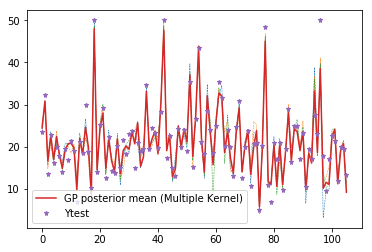

In [29]:
posteriorYtest2 = m_mul.posterior_samples_f(X_test, full_cov=True, size=3)
meanYtest2,_ = m_mul.predict(X_test,full_cov=True)

plt.figure()

plt.plot(posteriorYtest2,'--',lw=0.5)
plt.plot(meanYtest2,label='GP posterior mean (Multiple Kernel)')
plt.plot(y_test,'*',ms=5,label='Ytest')
plt.legend()
plt.show()

In [30]:
mean_absolute_percentage_error(y_test, meanYtest2)

10.065749550670711

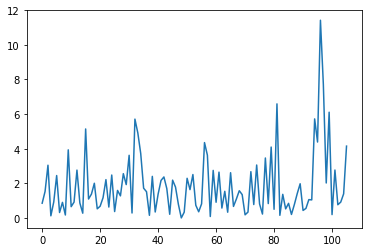

In [31]:
plt.plot(np.abs(y_test-meanYtest2))
plt.show(1)

The predictions are also better than before (we go from almost 99% and 10.24 of error to a 10%) as we can see in the graph.

### Sparse GP implementation (optional)

Try to implement an sparse version of the GP regressor, optimized to find a set of **inducing points** that the GP relies on to do the prediction. Measure the test error prediction for 20, 40, and 100 inducing points.

Elapse time : 0.681688s
Elapse time : 0.972393s
Elapse time : 3.444787s


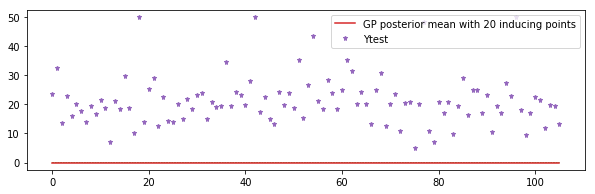

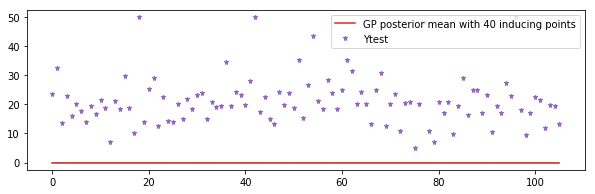

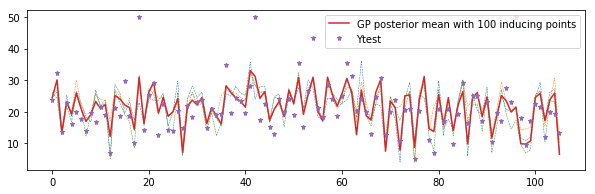

sparse_gp.,value,constraints,priors
inducing inputs,"(100, 13)",,
rbf.variance,66.48561510544528,+ve,
rbf.lengthscale,63.095599360221776,+ve,
Gaussian_noise.variance,111.94056706145543,+ve,


In [32]:
warnings.filterwarnings("ignore")

num_inducingpoints = [20,40,100]
MAPE_error = np.ones(len(num_inducingpoints))

for i in range(len(num_inducingpoints)): 
    start = time.time()
    
    Z = X_train[np.random.randint(0,X_train.shape[0],num_inducingpoints[i]),]

    m = GPy.models.SparseGPRegression(X_train,y_train,Z=Z)

    m.inducing_inputs.fix()
    m.optimize('bfgs')

    m.randomize()
    m.Z.unconstrain()
    m.optimize('bfgs')

    end = time.time()
    print("Elapse time : {0:2f}s".format(end - start))
    
    posteriorYtest2 = m.posterior_samples_f(X_test, full_cov=True, size=3)
    meanYtest2,_ = m.predict(X_test,full_cov=True)
    
    MAPE_error[i] = mean_absolute_percentage_error(y_test, meanYtest2)

    plt.figure(figsize=(10, 10))
    
    plt.subplot(3,1,i+1)
    plt.plot(posteriorYtest2,'--',lw=0.5)
    plt.plot(meanYtest2,label='GP posterior mean with {} inducing points'.format(num_inducingpoints[i]) )
    plt.plot(y_test,'*',ms=5,label='Ytest')
    plt.legend()
    
plt.show()
display(m)


In [33]:
mean_absolute_percentage_error(y_test, meanYtest2)

20.933404125825042

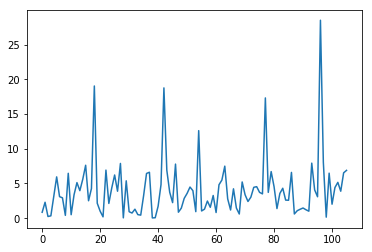

In [34]:
plt.plot(np.abs(y_test-meanYtest2))
plt.show(1)

It could be seen that with more inducing points the predictions are better (although we have not enhance the error value respect to the model with multiple kernels). Which is very remarkable here is the training time, that is very low (22 seconds against 509).